### Retrieve logTgapsMetric metadata from SQLite db and metric data from .npz files

This notebook plots the output of [00_computeLogTgapsMetric.ipynb](./00_computeLogTgapsMetric.ipynb).

### **Important:**  
As in the last notebook, in the next cell you need to update the `your_username` variable with **Your Username** (between the single quotes).  After you have done that, in principle, you should be able to run the notebook all at once instead of cell by cell. 

In [1]:
#Please enter your SciServer username between the single quotes below!
your_username = ''

In [1]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
from scipy.stats import chisquare

Import the sims_maf modules needed.

In [2]:
# import maf python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

#### **Important:**  
The following code is needed before importing the `opsimUtils` module if the module is not in the same directory as the current notebook. That is, you need add the directory where the `opsimUtils` module is located to the Python search path. 

In [1]:
# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

In [2]:
# import convenience functions
from opsimUtils import *

### 1. Read result SQLite db and read in metric data
Each time you run MAF on an opsim simulation, MAF produces two types of files:
1. `*.db`: A SQLite database storing metadata and summary statistics for each metric run on the opsims.
2. `*.npz`: A file storing metric values (e.g., those used to generated plots and histograms) per metric and per opsim. The name of this file is also stored in the above `*.db` files.

If you follow the [Introduction](./Introduction.ipynb) notebook, metadata for metrics run on each opsim will be stored in separate files (using the convention 'runName_result.db', otherwise all in one 'resultDb_sqlite.db' by default). You can easily retrieve the metedata from those files using the provided conveience functions.

**Note:** You can either provide the path to the directory where all result SQLite databases are stored or hard code the paths to each individual result database

To read result stored in files, we need the paths to two directories:
1. `resultDbPath`: The path to the directory where the `runName_result.db` metadata databases are stored.
2. `metricDataPath`: The path to the directory where the actual metric data (`*.npz` files) are stored.

In [4]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

# user provided paths
resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/'.format(your_username)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/'.format(your_username)

In [6]:
# get a dictionary of resultDb from given directory
resultDbs = getResultsDbs(resultDbPath)

Setup bin spacing that will be used for plots below.

In [7]:
#From 30s to 10 years (~3e8s), converted to days, 99 bins
bins=np.logspace(np.log10(30.0/60./60./24.),np.log10(3e8/60./60./24.),99)

Make histograms of the distribution of $\Delta t$, specifically in log space.  The left panel has a linear $y$ axis.  The middle panel has a log $y$ axis.  The right panel shows the cumulative distribution.  An "ideal" cadence (arguably) would have a uniform distribution as indicated by the yellow line in the right panel.

What we are doing is actually summing all of the healpix histograms for a given opSim.  Then we are computing a sort of chi-square (with respect to a uniform distribution).  It is NOT at all clear that this is the optimal (or even correct) thing to do, but the point here is to just get something working that can be discussed and improved upon.

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

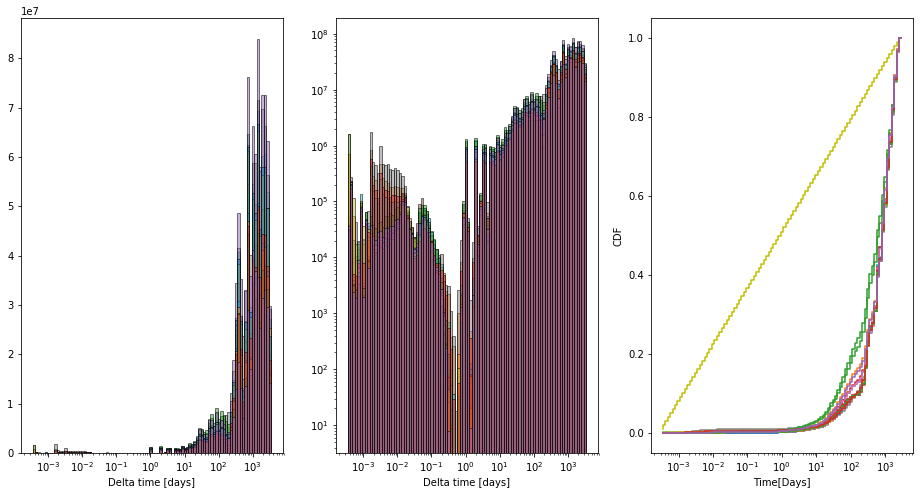

In [8]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts = {}
chisqDict = {}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
for i,runName in enumerate(resultDbs):
    if (i<=74):
        bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)
        bdict = bundleDicts[runName]
        logTgaps = bdict[(1,'logTgaps observationStartMJD')]
        #print(logTgaps.metricValues)
    
        mask = logTgaps.metricValues.mask #get rid of healpix with no data.
        data = logTgaps.metricValues.data[~mask]
        
        ax1.bar(bins[:-1], data.sum(), width=np.diff(bins), ec="k", align="edge", alpha=0.5)
        ax1.set_xscale('log')
        #ax1.set_yscale('log')
        ax1.set_xlabel('Delta time [days]')
        
        ax2.bar(bins[:-1], data.sum(), width=np.diff(bins), ec="k", align="edge", alpha=0.5)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('Delta time [days]')
        #plt.savefig('test2.png')
    
        #Total number of observation pairs
        total = data.sum().sum()
        uniform = np.zeros_like(data.sum()) + total/len(data.sum())
        #Make cumulative distributions of those
        y1 = uniform.cumsum()
        y1 = y1/y1[-1]
        if (i==0):
            ax3.step(bins[:-1], y1, color='y')

        y2 = data.sum().cumsum()
        y2 = y2/y2[-1]
        ax3.step(bins[:-1], y2)
        ax3.set_xscale('log')
        ax3.set_xlabel('Time[Days]')
        ax3.set_ylabel('CDF')
    
        #Compute a sort of chi-square
        chisq,p = chisquare(f_obs=data.sum(),f_exp=uniform)
        #print(chisq,p)
        chisqDict[runName]=chisq
        #print(chisqDict)

In [9]:
print(chisqDict)

{'wfd_depth_scale0.85_noddf_v1.4_10yrs': 2549768768.7779307, 'twilight_neo_mod2_v1.4_10yrs': 2822361053.1987023, 'weather_0.3_v1.4_10yrs': 2181850368.4948587, 'pair_strategy_4_v1.4_10yrs': 2177366191.367549, 'short_exp_2ns_1expt_v1.4_10yrs': 2742910951.0253887, 'sat_dodge_v1.4_10yrs': 2234170649.8967667, 'footprint_big_sky_dustv1.4_10yrs': 2184518043.5129023, 'roll_mod2_dust_sdf_0.20_v1.4_10yrs': 1823027288.0028632, 'pair_strategy_1_v1.4_10yrs': 2172733326.66878, 'alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs': 1838984012.962046, 'wfd_depth_scale0.99_v1.4_10yrs': 2409603924.250828, 'dcr_nham5_v1.4_10yrs': 2019931381.398596, 'rolling_mod6_sdf_0.20_v1.4_10yrs': 1462626792.0285494, 'spiders_v1.4_10yrs': 2173710711.159663, 'agnddf_v1.4_10yrs': 2358984880.5626335, 'twi_filters_5_v1.4_10yrs': 2170049883.681623, 'baseline_2snapsv1.4_10yrs': 1844786332.8651795, 'wfd_depth_scale0.70_noddf_v1.4_10yrs': 2546403746.0621877, 'baseline_v1.4_10yrs': 2154490013.296554, 'short_exp_5ns_1expt_v1.4_10yrs': 35629

Now let's sort the chi-square values and take a look at the best and worst opSims (according to this metric).

In [10]:
chisqDictSorted = sorted(chisqDict.items(), key=lambda x: x[1])

In [11]:
print(chisqDictSorted)

[('rolling_mod6_sdf_0.10_v1.4_10yrs', 1386650677.5087564), ('rolling_mod6_sdf_0.20_v1.4_10yrs', 1462626792.0285494), ('roll_mod2_dust_sdf_0.20_v1.4_10yrs', 1823027288.0028632), ('footprint_newAv1.4_10yrs', 1835760041.808568), ('alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs', 1838984012.962046), ('baseline_2snapsv1.4_10yrs', 1844786332.8651795), ('bulges_i_heavy_v1.4_10yrs', 1890661188.1978917), ('bulges_cadence_i_heavy_v1.4_10yrs', 1891667863.4401512), ('rolling_mod3_sdf_0.20_v1.4_10yrs', 1899803588.658816), ('rolling_mod3_sdf_0.10_v1.4_10yrs', 1905757829.4056504), ('bulges_cadence_bulge_wfd_v1.4_10yrs', 1906412269.9554546), ('bulges_bulge_wfd_v1.4_10yrs', 1907235139.3679912), ('bulges_bs_v1.4_10yrs', 1916564206.8096013), ('var_expt_v1.4_10yrs', 1922499133.7591147), ('bulges_cadence_bs_v1.4_10yrs', 1922651313.2989872), ('footprint_newBv1.4_10yrs', 1928393815.1279619), ('twi_filters_1_v1.4_10yrs', 2006442234.2462895), ('dcr_nham5_v1.4_10yrs', 2019931381.398596), ('dcr_nham4_v1.4_10yrs', 203396

In [12]:
#Print out the runName and chi-square in order.
[print(key , " :: " , value) for (key, value) in chisqDictSorted]

rolling_mod6_sdf_0.10_v1.4_10yrs  ::  1386650677.5087564
rolling_mod6_sdf_0.20_v1.4_10yrs  ::  1462626792.0285494
roll_mod2_dust_sdf_0.20_v1.4_10yrs  ::  1823027288.0028632
footprint_newAv1.4_10yrs  ::  1835760041.808568
alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs  ::  1838984012.962046
baseline_2snapsv1.4_10yrs  ::  1844786332.8651795
bulges_i_heavy_v1.4_10yrs  ::  1890661188.1978917
bulges_cadence_i_heavy_v1.4_10yrs  ::  1891667863.4401512
rolling_mod3_sdf_0.20_v1.4_10yrs  ::  1899803588.658816
rolling_mod3_sdf_0.10_v1.4_10yrs  ::  1905757829.4056504
bulges_cadence_bulge_wfd_v1.4_10yrs  ::  1906412269.9554546
bulges_bulge_wfd_v1.4_10yrs  ::  1907235139.3679912
bulges_bs_v1.4_10yrs  ::  1916564206.8096013
var_expt_v1.4_10yrs  ::  1922499133.7591147
bulges_cadence_bs_v1.4_10yrs  ::  1922651313.2989872
footprint_newBv1.4_10yrs  ::  1928393815.1279619
twi_filters_1_v1.4_10yrs  ::  2006442234.2462895
dcr_nham5_v1.4_10yrs  ::  2019931381.398596
dcr_nham4_v1.4_10yrs  ::  2033960262.0399406
rolli

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [13]:
#Identify the best and worst 3 opSims
print(chisqDictSorted[:3]) #top 3
print(chisqDictSorted[-3:]) #bottom 3

[('rolling_mod6_sdf_0.10_v1.4_10yrs', 1386650677.5087564), ('rolling_mod6_sdf_0.20_v1.4_10yrs', 1462626792.0285494), ('roll_mod2_dust_sdf_0.20_v1.4_10yrs', 1823027288.0028632)]
[('short_exp_5ns_1expt_v1.4_10yrs', 3562955436.560812), ('twilight_neo_mod1_v1.4_10yrs', 3794587559.1264997), ('weather_1.2_v1.4_10yrs', 4281568699.3925595)]


In [14]:
top3bot3 = chisqDictSorted[:3]+chisqDictSorted[-3:]
print(top3bot3)

[('rolling_mod6_sdf_0.10_v1.4_10yrs', 1386650677.5087564), ('rolling_mod6_sdf_0.20_v1.4_10yrs', 1462626792.0285494), ('roll_mod2_dust_sdf_0.20_v1.4_10yrs', 1823027288.0028632), ('short_exp_5ns_1expt_v1.4_10yrs', 3562955436.560812), ('twilight_neo_mod1_v1.4_10yrs', 3794587559.1264997), ('weather_1.2_v1.4_10yrs', 4281568699.3925595)]


Now we'll plot the best and worst opsims on the same plot.

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


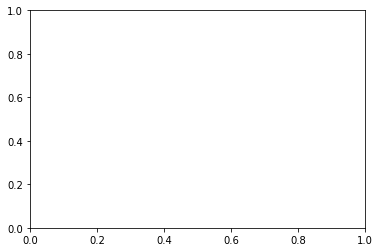

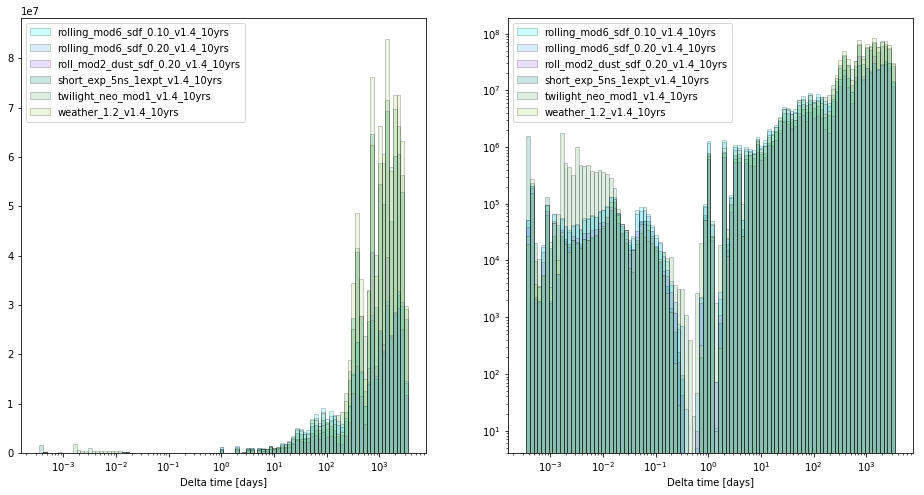

In [15]:
from cycler import cycler

cmcool = plt.cm.cool
cmwarm = plt.cm.summer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
for i,vals in enumerate(top3bot3):
    runName = vals[0]
    bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)
    bdict = bundleDicts[runName]
    logTgaps = bdict[(1,'logTgaps observationStartMJD')]
    
    mask = logTgaps.metricValues.mask #get rid of healpix with no data.
    data = logTgaps.metricValues.data[~mask]
    #plt.xlim(-4,4)
    
    n=3
    if (i==0):
        ax1.set_prop_cycle(cycler('color', [cmcool(1.*j/n) for j in range(n)]))
    if (i==3):
        ax1.set_prop_cycle(cycler('color', [cmwarm(1.*j/n) for j in range(n)]))
        
    ax1.bar(bins[:-1], data.sum(), width=np.diff(bins), ec="k", align="edge", alpha=0.2, label=runName)      
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
    ax1.set_xlabel('Delta time [days]')
    ax1.legend(loc='upper left')
    
    if (i==0):
        ax2.set_prop_cycle(cycler('color', [cmcool(1.*j/n) for j in range(n)]))
    if (i==3):
        ax2.set_prop_cycle(cycler('color', [cmwarm(1.*j/n) for j in range(n)]))
        
    ax2.bar(bins[:-1], data.sum(), width=np.diff(bins), ec="k", align="edge", alpha=0.2, label=runName)      
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Delta time [days]')
    ax2.legend(loc='upper left')
    
    plt.savefig('test_top3bot3.png')

We can probably improve this presentation considerably, but what we find is that the "bad" opSims have lots of observations at long time separation, which must be coming from a relative lack at other times.  Though it does look like some of the "bad" ones have a lot of observations in the ~half-day gap and at short time separations, which arguably isn't bad.  So, further investigation is warranted.